pillcam dataset split into neg/pos and trained using resnet.py witouth augmentation or ds normalization.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet50',
    "DS_INFO": 'binary',
    "resample": True,
    "neg_class": ['polyps'],
    "NUM_EPOCHS": 5,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (128, 128, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Negative class names:
        - polyps
Positive class names:
        - esophagitis
        - normal-pylorus
        - ulcerative-colitis
        - normal-cecum
        - normal-z-line
        - dyed-resection-margins
        - dyed-lifted-polyps

Negative samples:  1000 | 12.50%
Positive samples:  7000 | 87.50%

Total number of images: 8000
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[1 1 0 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 1]
[1 1 1 1 1 1 0 1 0 1]
[1 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 1 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]

Resamplng the dataset..

Fractions:  [0.125 0.875]
Counts:  [1000. 7000.]

[1 0 1 1 1 1 0 0 0 0]
[0 1 0 1 1 0 1 1 1 0]
[1 1 0 0 1 0 0 1 0 1]
[0 0 0 1 0 0 0 0 0 0]
[1 1 0 0 1 1 1 0 0 1]
[0 1 0 1 1 0 1 1 0 1]
[0 0 1 1 1 1 1 0 1 0]
[0 0 1 0 1 0 1 1 1 1]
[1 0 1 0 0 1 0 1 1 1]
[0 0 1 1 0 1 0 1 1 0]

Full dataset sample size:           -2
Train dataset sample size:          -2
Test 

## Training
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D

In [5]:
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=config['IMG_SIZE'])

In [6]:
res_net.trainable = False

global_average_layer = GlobalAveragePooling2D()
output_layer = Dense(config['NUM_CLASSES'], activation='softmax')

resnet50_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [7]:
if config['verbosity'] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
resnet50_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/resnet50', update_freq='batch')]

In [9]:
history = resnet50_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 87 steps, validate for 18 steps
Epoch 1/5
87/87 [==============================] - 10s 114ms/step - loss: 0.7766 - accuracy: 0.5000 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 2/5
87/87 [==============================] - 5s 62ms/step - loss: 0.7238 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/5
87/87 [==============================] - 6s 65ms/step - loss: 0.7108 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/5
87/87 [==============================] - 5s 61ms/step - loss: 0.7055 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/5
87/87 [==============================] - 6s 64ms/step - loss: 0.7014 - accuracy: 0.5000 - val_loss: 0.6954 - val_accuracy: 0.5000


`Keras`
Save/load the model

In [10]:
# resnet50_model.save('models/{}.h5'.format(model_name))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [11]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 193s - loss: 0.6954 - accuracy: 0.5000


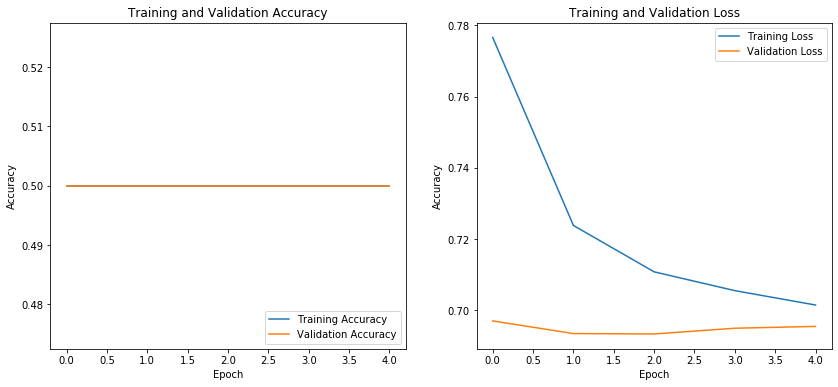

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [16]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

KeyboardInterrupt: 

0.4644 Negative
0.5356 Positive

Label: Positive
Predicton: Positive


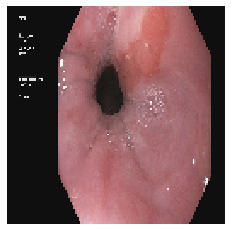

In [14]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [15]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label                     pred                     
---  ------------------------- -------------------------
  0  Negative                  Positive                   Wrong
  1  Positive                  Positive                 
  2  Negative                  Positive                   Wrong
  3  Negative                  Positive                   Wrong
  4  Positive                  Positive                 
  5  Negative                  Positive                   Wrong
  6  Positive                  Positive                 
  7  Positive                  Positive                 
  8  Negative                  Positive                   Wrong
  9  Positive                  Positive                 
 10  Negative                  Positive                   Wrong
 11  Positive                  Positive                 
 12  Positive                  Positive                 
 13  Positive                  Positive                 
 14  Positive                  Positive       